In [1]:
# Setup
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/My\ Drive/BDSA_Project
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/BDSA_Project
 annotations			 model_mobilenetv2.pt.data-00000-of-00001
 checkpoint			 model_mobilenetv2.pt.index
'Coronavirus Template.gslides'	 model.pt
 demo_ppt.gslides		 output
 final_report.gslides		 pretrained_caffe_ssd
 images				 pytorch-fasterrcnn.ipynb
 keras_loss_function		 pytorch-ssd.ipynb
 model_detectron2.ipynb		 Team6-WorshopPresentation.mov
 model_fasterrcnn.pt		 Voiceovers
 model_mobilenetv2		'webcam implementation'
 model_mobilenetv2.ipynb	'Workshop Presentation.gslides'


In [2]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
import json
!pip install xmltodict
from keras.optimizers import Adam, SGD
# from keras_loss_function.keras_ssd_loss import SSDLoss
import xmltodict
from google.colab.patches import cv2_imshow
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [3]:
directory = "./annotations/"
image_directory = "./images/"

In [4]:
cvNet = cv2.dnn.readNetFromCaffe('./pretrained_caffe_ssd/architecture.txt','./pretrained_caffe_ssd/weights.caffemodel')

In [5]:
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)

def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

In [6]:
jsonfiles= []
for i in os.listdir(directory):
  xml_file = open(directory+i)
  data_dict = xmltodict.parse(xml_file.read())
  xml_file.close()
  json_data = json.dumps(data_dict)
  json_dict = json.loads(json_data)
  jsonfiles.append(json_dict)
  
jsonfiles[0]

{'annotation': {'filename': 'maksssksksss100.png',
  'folder': 'images',
  'object': [{'bndbox': {'xmax': '245',
     'xmin': '189',
     'ymax': '88',
     'ymin': '30'},
    'difficult': '0',
    'name': 'with_mask',
    'occluded': '0',
    'pose': 'Unspecified',
    'truncated': '0'},
   {'bndbox': {'xmax': '400', 'xmin': '387', 'ymax': '75', 'ymin': '54'},
    'difficult': '0',
    'name': 'with_mask',
    'occluded': '0',
    'pose': 'Unspecified',
    'truncated': '0'},
   {'bndbox': {'xmax': '163', 'xmin': '118', 'ymax': '126', 'ymin': '87'},
    'difficult': '0',
    'name': 'with_mask',
    'occluded': '0',
    'pose': 'Unspecified',
    'truncated': '0'}],
  'segmented': '0',
  'size': {'depth': '3', 'height': '226', 'width': '400'}}}

In [7]:
column_names = ["name", "x1", "x2", "y1", "y2", "classname"]
df = pd.DataFrame(columns = column_names)
df

,name,x1,x2,y1,y2,classname


In [8]:
for jf in jsonfiles:
  one = False
  for o in jf['annotation']['object']:
    try:
      df.loc[len(df.index)] = [jf['annotation']['filename'], int(o['bndbox']['xmin']), int(o['bndbox']['xmax']), int(o['bndbox']['ymin']), int(o['bndbox']['ymax']), o['name']]
    except TypeError:
      one = True

  if (one):
    o = jf['annotation']['object']
    df.loc[len(df.index)] = [jf['annotation']['filename'], int(o['bndbox']['xmin']), int(o['bndbox']['xmax']), int(o['bndbox']['ymin']), int(o['bndbox']['ymax']), o['name']]

df.head()

,name,x1,x2,y1,y2,classname
0,maksssksksss100.png,189,245,30,88,with_mask
1,maksssksksss100.png,387,400,54,75,with_mask
2,maksssksksss100.png,118,163,87,126,with_mask
3,maksssksksss106.png,154,423,51,391,with_mask
4,maksssksksss101.png,48,164,294,400,with_mask


In [9]:
set(df['classname'])

{'mask_weared_incorrect', 'with_mask', 'without_mask'}

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


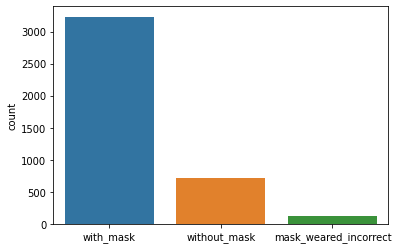

In [10]:
sns.countplot(list(df['classname']))

In [11]:
# 90 - 10 train/val test split
np.random.seed(100)
mask = np.random.rand(len(df)) < 0.9
df_train = df[mask]
df_test = df[~mask]

print(df_train,"\n")
print(df_test,"\n")

                     name   x1   x2   y1   y2     classname
0     maksssksksss100.png  189  245   30   88     with_mask
1     maksssksksss100.png  387  400   54   75     with_mask
2     maksssksksss100.png  118  163   87  126     with_mask
3     maksssksksss106.png  154  423   51  391     with_mask
4     maksssksksss101.png   48  164  294  400     with_mask
...                   ...  ...  ...  ...  ...           ...
4067  maksssksksss851.png   66  156  205  330     with_mask
4068   maksssksksss86.png   22   77  121  181     with_mask
4069   maksssksksss86.png  231  290   76  144     with_mask
4070   maksssksksss86.png  335  395  135  198  without_mask
4071   maksssksksss86.png   78  111  105  149  without_mask

[3665 rows x 6 columns] 

                     name   x1   x2   y1   y2  classname
15    maksssksksss116.png  160  193   79  118  with_mask
21    maksssksksss107.png  121  212  192  312  with_mask
36    maksssksksss119.png  132  153   47   71  with_mask
50     maksssksksss12.png

In [12]:
data = []
img_size = 124

with_mask = ['with_mask']
without_mask = ["without_mask"]
mask_weared_incorrect = ['mask_weared_incorrect']

labels={'mask_weared_incorrect':0, 'with_mask':1, 'without_mask':2}
for ind in df_train.index:
  x1, x2, y1, y2 = df_train['x1'][ind], df_train['x2'][ind], df_train['y1'][ind], df_train['y2'][ind]
  img = cv2.imread(os.path.join(image_directory,df_train['name'][ind]),1)
  img = img[y1:y2,x1:x2]
  img = cv2.resize(img,(img_size,img_size))
  data.append([img, labels[df_train['classname'][ind]]])
  # cv2_imshow(img)

random.shuffle(data)

1


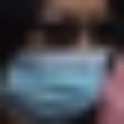

1


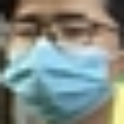

1


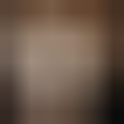

1


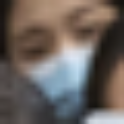

0


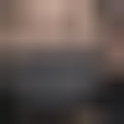

1


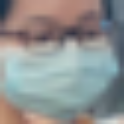

2


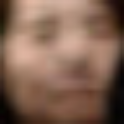

0


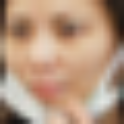

2


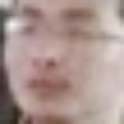

1


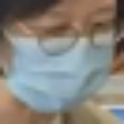

1


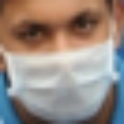

1


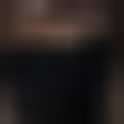

2


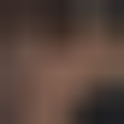

0


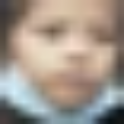

1


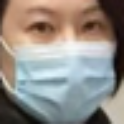

1


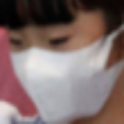

1


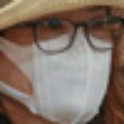

1


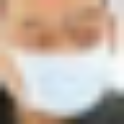

1


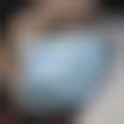

2


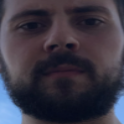

1


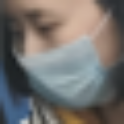

In [13]:
for i,d in enumerate(data):
  print(d[1])
  cv2_imshow(d[0])
  if(i==20):
    break

#TRAIN

In [14]:
X, Y = list(), list()
for features,label in data:
    X.append(features)
    temp = list([0,0,0])
    temp[label] = 1
    Y.append(temp)

X[0].shape

(124, 124, 3)

In [15]:
X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)
print(Y.shape)

(3665, 3)


In [16]:
xtrain,xval,ytrain,yval=train_test_split(X, Y, train_size=0.7, random_state=42)

In [17]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 124, 124, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 64)      18496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 120, 120, 128)     73856     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 60, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 460800)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 460800)            0

In [19]:
def smooth_l1_loss(y_true, y_pred):
    return 100*tf.compat.v1.losses.huber_loss(y_true, y_pred)

In [27]:
adam = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = SGD(lr=0.005, momentum=1.0, decay=0.0, nesterov=False)

model.compile(loss= 'categorical_crossentropy', #smooth_l1_loss, 
              optimizer=sgd,
              metrics='accuracy')

In [28]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)
datagen.fit(xtrain)

In [29]:
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=32),
                    steps_per_epoch=xtrain.shape[0]//32,
                    epochs=5,
                    verbose=1,
                    validation_data=(xval, yval))

Epoch 1/5
80/80 [==============================] - 554s 7s/step - loss: 0.6109 - accuracy: 0.7908 - val_loss: 0.5961 - val_accuracy: 0.8000
Epoch 2/5
80/80 [==============================] - 537s 7s/step - loss: 0.5999 - accuracy: 0.7912 - val_loss: 0.5922 - val_accuracy: 0.8000
Epoch 3/5
80/80 [==============================] - 539s 7s/step - loss: 0.6014 - accuracy: 0.7896 - val_loss: 0.5942 - val_accuracy: 0.8000
Epoch 4/5
80/80 [==============================] - 536s 7s/step - loss: 0.5982 - accuracy: 0.7912 - val_loss: 0.5913 - val_accuracy: 0.8000
Epoch 5/5
80/80 [==============================] - 535s 7s/step - loss: 0.5986 - accuracy: 0.7916 - val_loss: 0.5924 - val_accuracy: 0.8000


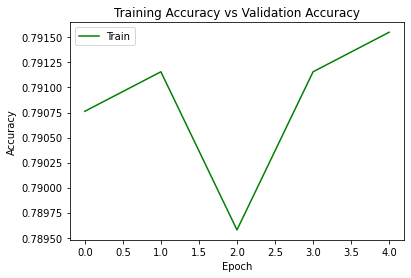

In [30]:
plt.plot(history.history['accuracy'],'g')
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

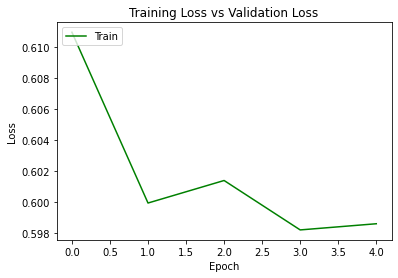

In [31]:
plt.plot(history.history['loss'],'g')
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


#Model Testing

In [32]:
print(len(df_test["name"]),len(df_test["name"].unique()))

407 258


In [33]:
test = df_test.sample(15)
test

,name,x1,x2,y1,y2,classname
3817,maksssksksss826.png,159,167,74,83,with_mask
2721,maksssksksss58.png,74,86,61,74,with_mask
3919,maksssksksss93.png,171,195,78,103,with_mask
3464,maksssksksss773.png,83,89,24,31,without_mask
1032,maksssksksss301.png,193,219,43,72,with_mask
1398,maksssksksss352.png,48,91,90,133,without_mask
1133,maksssksksss297.png,294,306,22,35,without_mask
1653,maksssksksss424.png,287,297,106,116,with_mask
674,maksssksksss257.png,342,379,34,71,with_mask
3264,maksssksksss70.png,326,353,117,144,with_mask


In [34]:
gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign={'0':['mask_weared_incorrect',(255,0,0)], '1':['with_mask',(0,0,255)], '2':['without_mask',(0,255,0)]}

<Figure size 1008x1008 with 0 Axes>

In [44]:
for index, row in test.iterrows():
  image =  cv2.imread(os.path.join(image_directory,row['name']),1)
  image =  adjust_gamma(image, gamma=gamma)
  (h, w) = image.shape[:2]
  blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
  cvNet.setInput(blob)
  detections = cvNet.forward()

  for i in range(0, detections.shape[2]):
        try:
            temp = detections[0, 0, i, :]
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            # cv2_imshow(frame)
            confidence = detections[0, 0, i, 2]
            if confidence > 0.12:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                label_Y = np.argmax(result[0])
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)

        except:
          pass
          
  # axes.append(fig.add_subplot(rows, cols, index+1))
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.show()
  
  if (index==10):
    break

Output hidden; open in https://colab.research.google.com to view.